/Users/karan/Developer/ChaiBachai

0: 640x384 1 rim, 1 tea, 255.0ms
Speed: 1.5ms preprocess, 255.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        726         486]
tea_peak [        423         738]




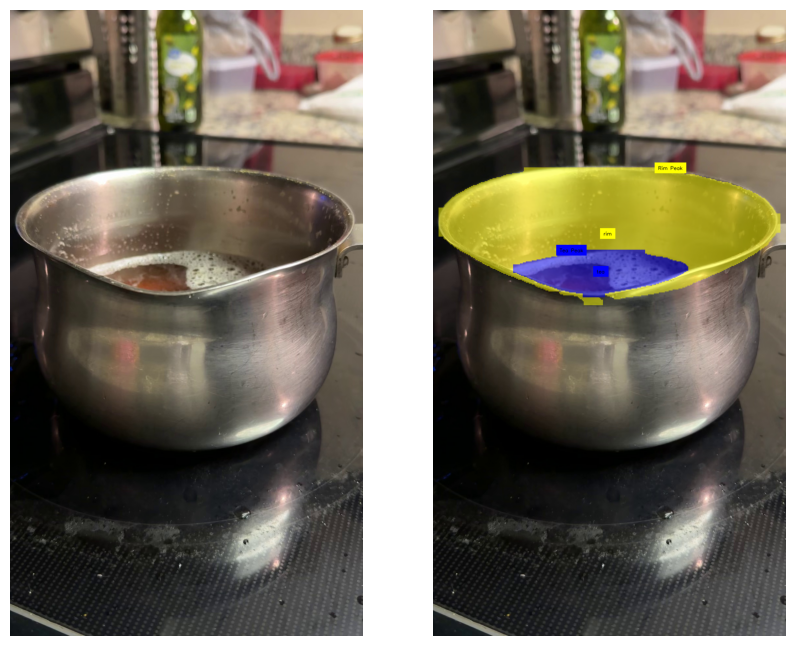


0: 640x384 1 rim, 1 tea, 289.6ms
Speed: 1.4ms preprocess, 289.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        273         486]
tea_peak [        447         738]




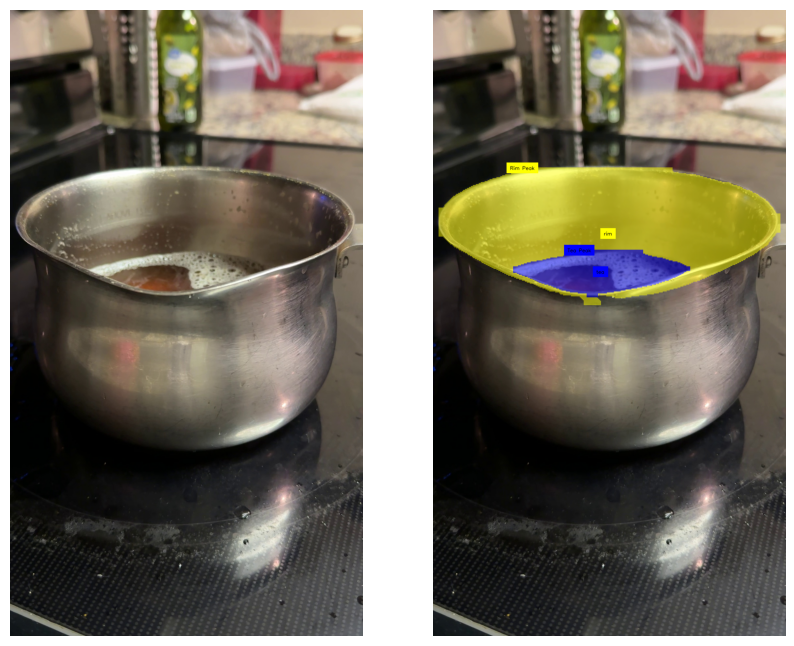


0: 640x384 1 rim, 1 tea, 252.7ms
Speed: 1.4ms preprocess, 252.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        279         486]
tea_peak [        450         738]




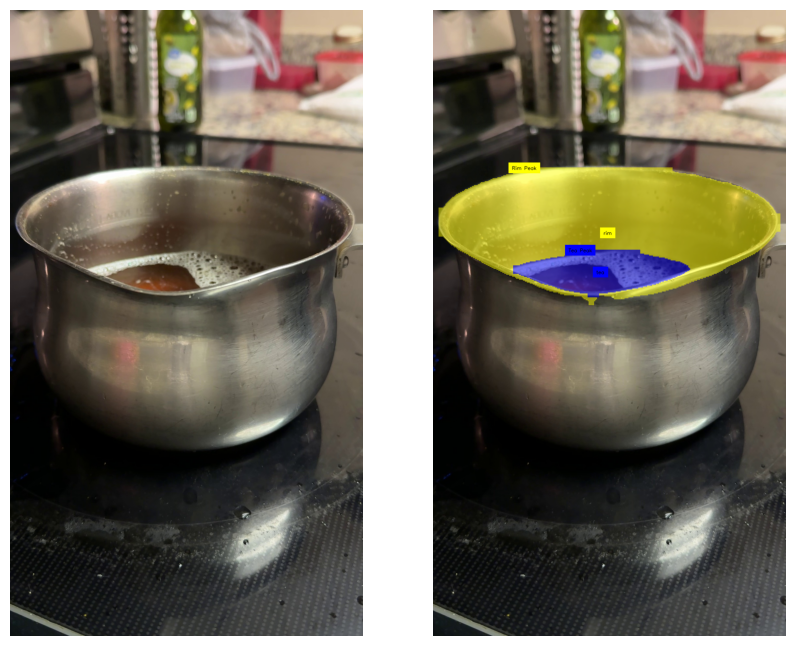


0: 640x384 1 rim, 1 tea, 250.2ms
Speed: 1.4ms preprocess, 250.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        273         486]
tea_peak [        450         738]




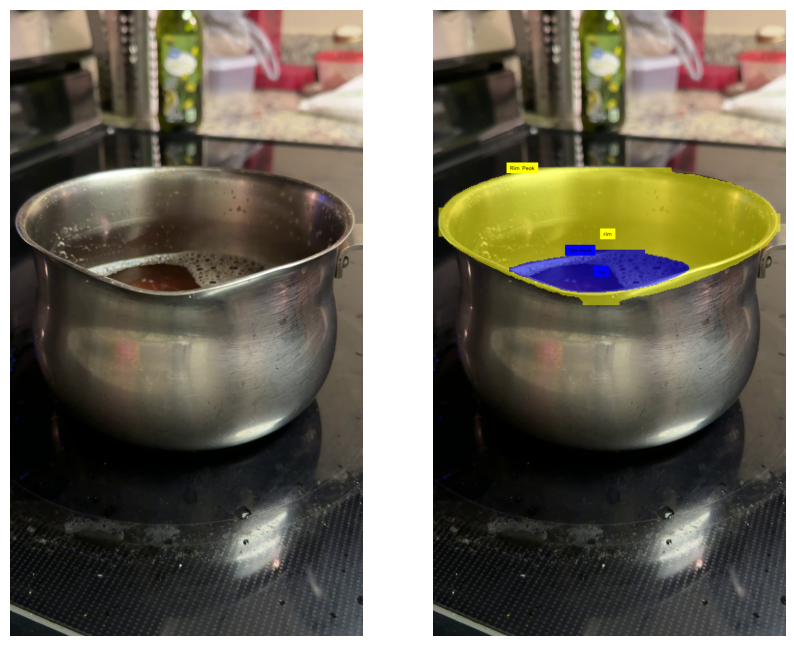


0: 640x384 1 rim, 1 tea, 249.5ms
Speed: 1.6ms preprocess, 249.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        300         486]
tea_peak [        444         738]




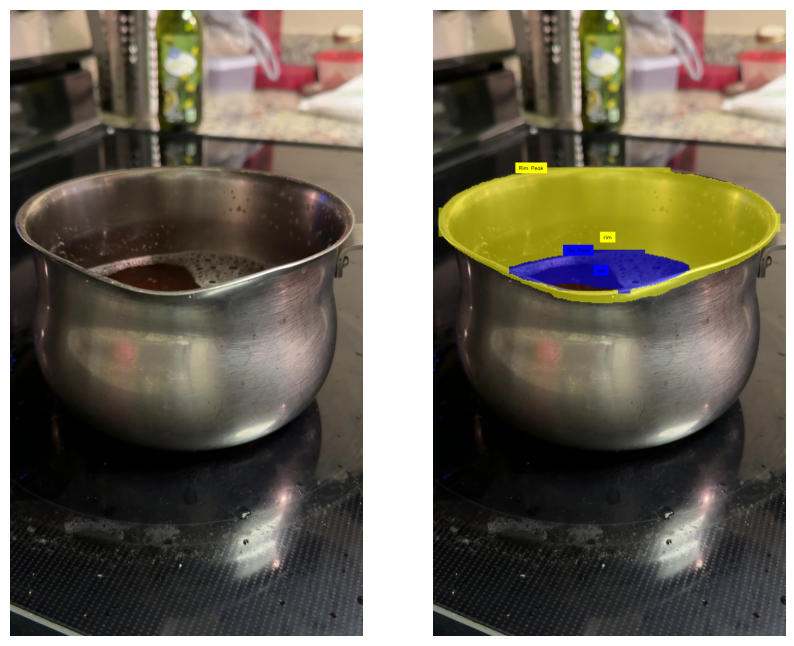


0: 640x384 1 rim, 1 tea, 248.1ms
Speed: 1.5ms preprocess, 248.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        351         474]
tea_peak [        492         618]




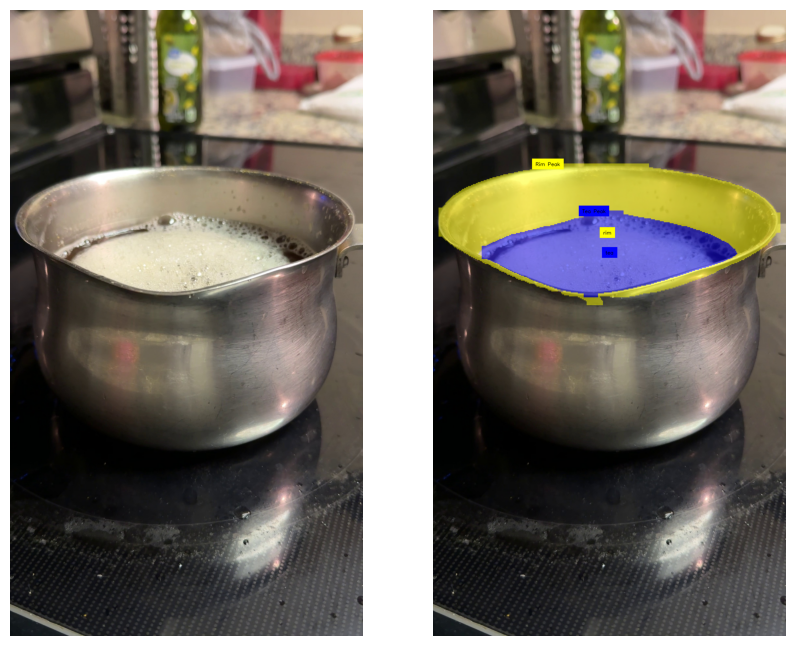


0: 640x384 1 rim, 1 tea, 259.2ms
Speed: 1.6ms preprocess, 259.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        657         474]
tea_peak [        432         630]




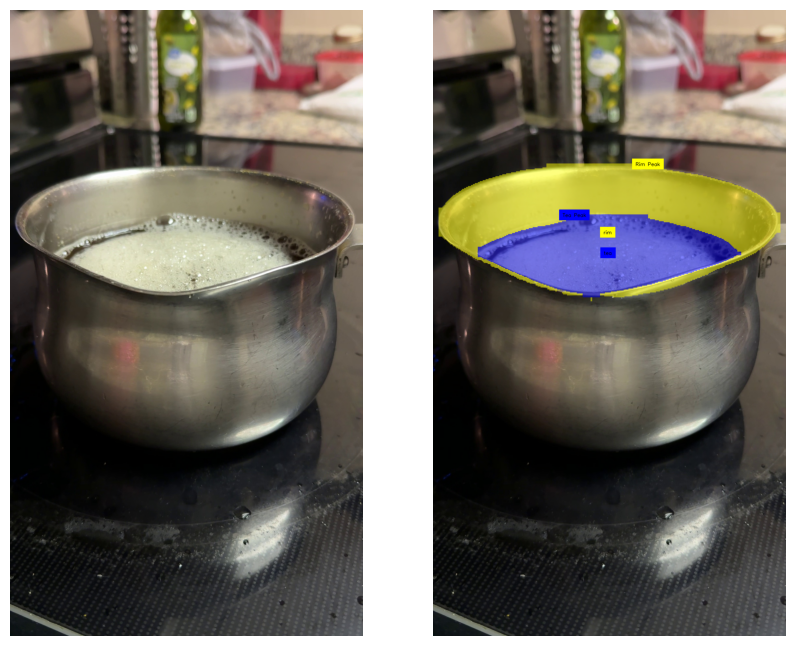


0: 640x384 1 rim, 1 tea, 247.9ms
Speed: 1.5ms preprocess, 247.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        360         474]
tea_peak [        438         630]




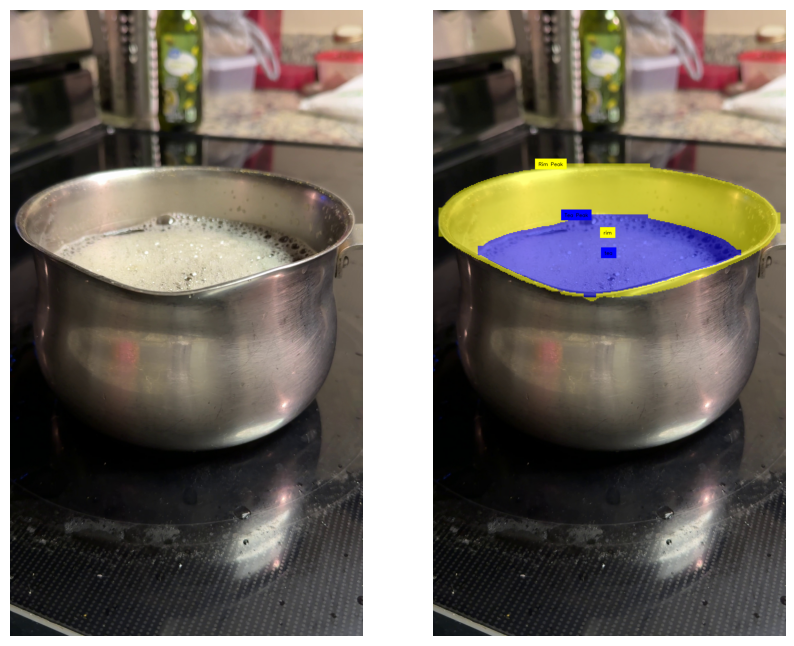


0: 640x384 1 rim, 1 tea, 242.2ms
Speed: 2.2ms preprocess, 242.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        660         474]
tea_peak [        420         630]




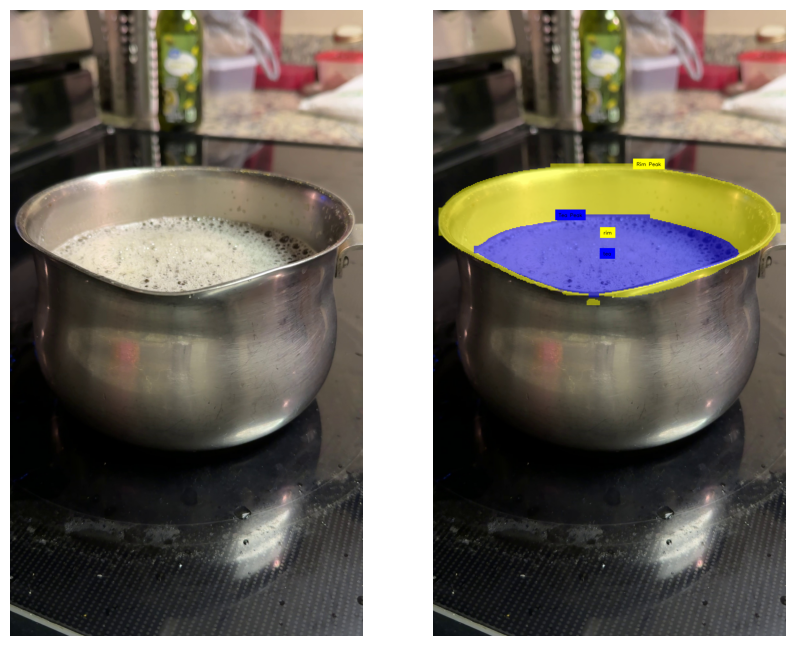


0: 640x384 1 rim, 1 tea, 268.2ms
Speed: 1.3ms preprocess, 268.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        732         486]
tea_peak [        438         630]




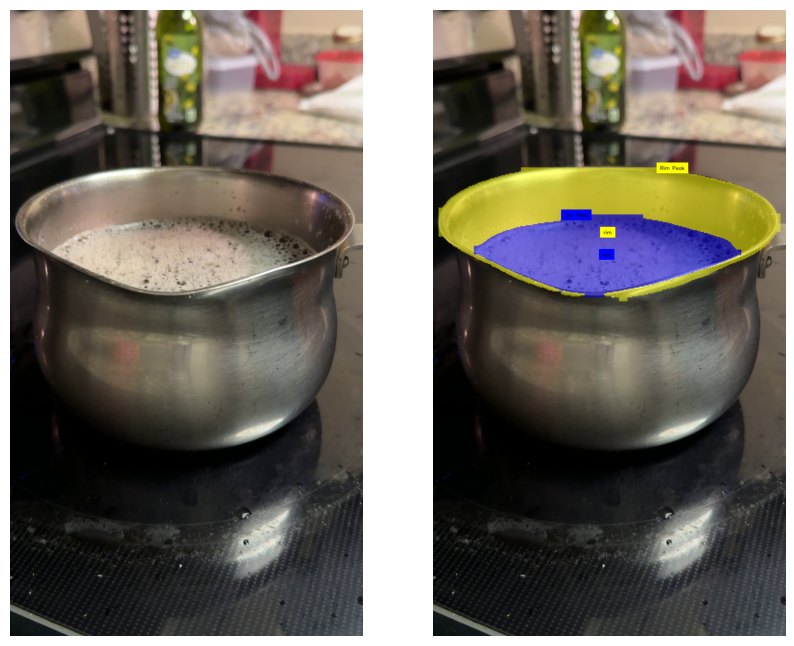


0: 640x384 1 rim, 1 tea, 268.6ms
Speed: 1.4ms preprocess, 268.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        681         474]
tea_peak [        357         486]




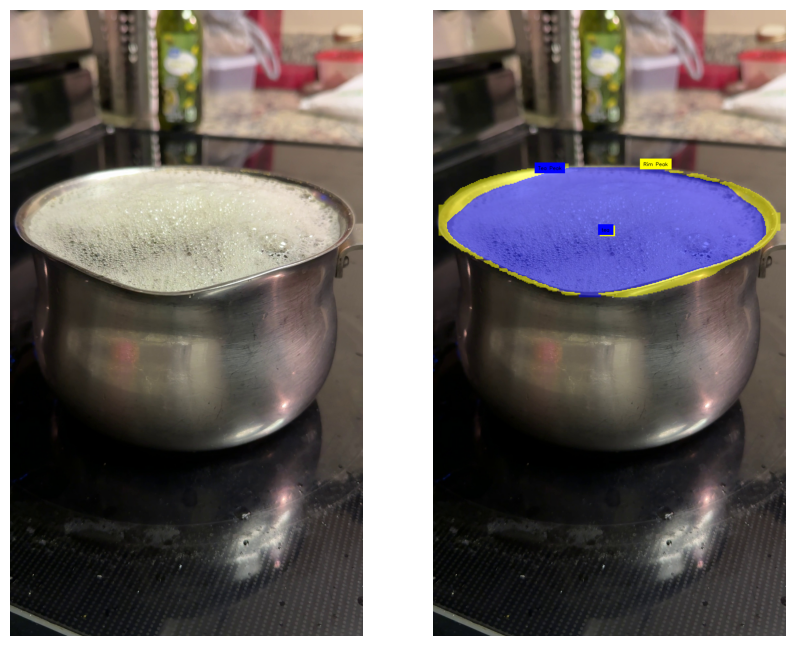


0: 640x384 1 rim, 1 tea, 383.8ms
Speed: 48.5ms preprocess, 383.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        378         474]
tea_peak [        684         474]




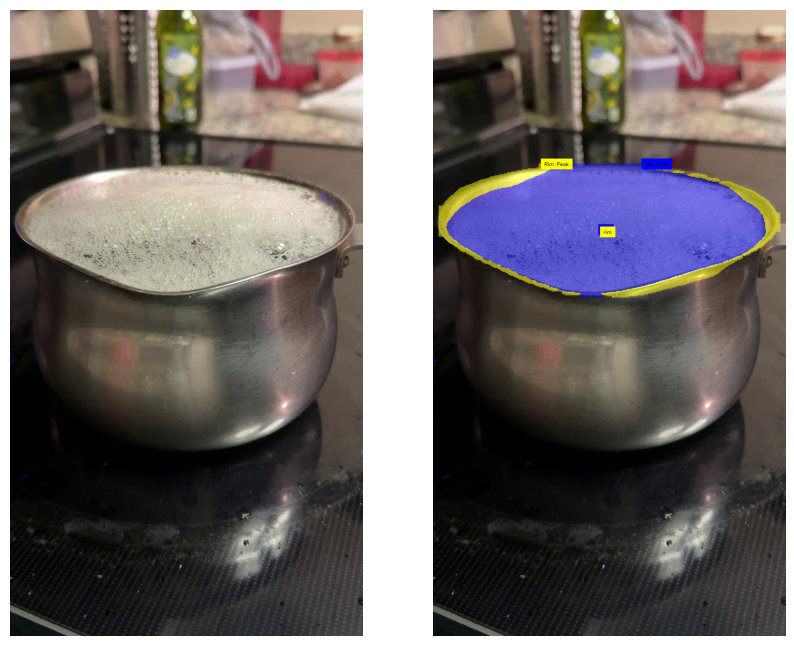


0: 640x384 1 rim, 1 tea, 276.1ms
Speed: 1.3ms preprocess, 276.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        699         474]
tea_peak [        378         486]




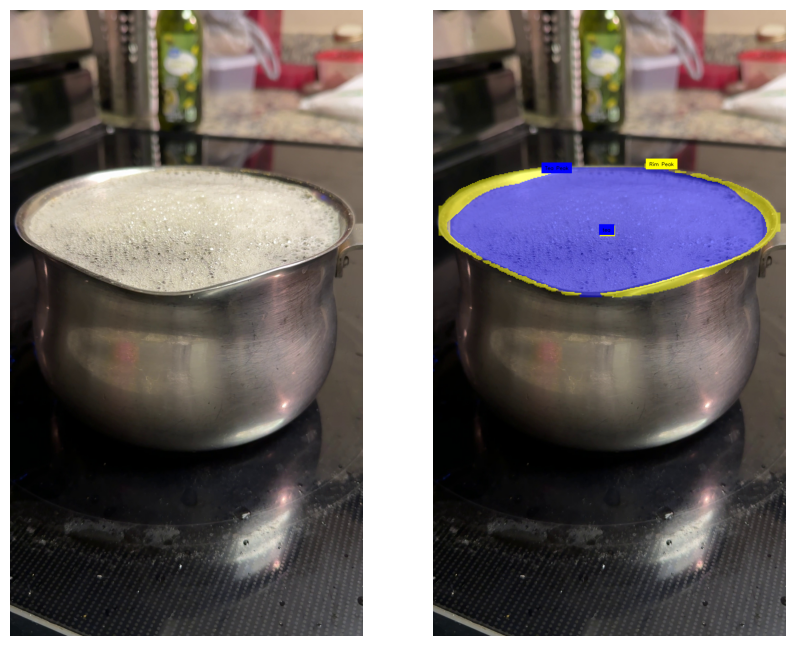


0: 640x384 1 rim, 1 tea, 250.7ms
Speed: 1.3ms preprocess, 250.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        687         474]
tea_peak [        378         486]




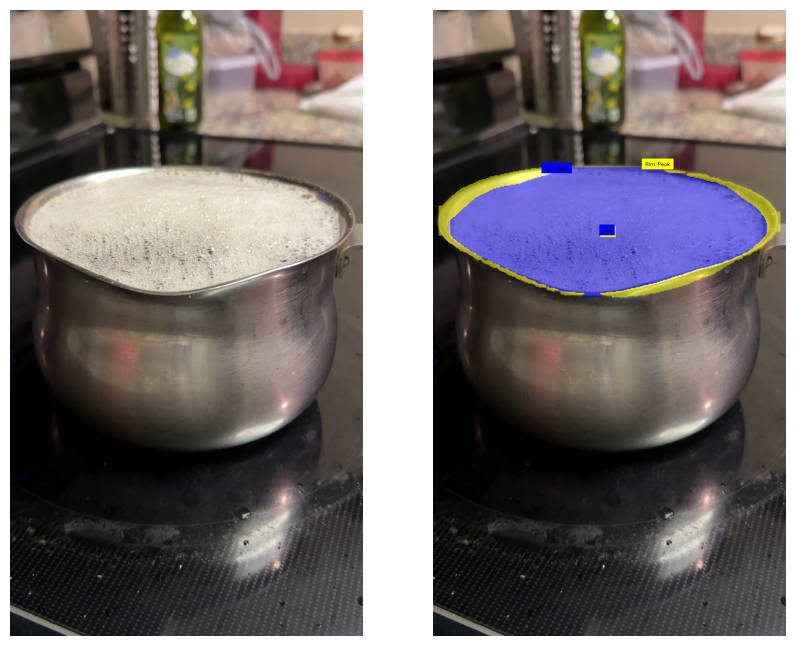


0: 640x384 1 rim, 1 tea, 344.9ms
Speed: 1.2ms preprocess, 344.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
rim_peak [        693         474]
tea_peak [        375         486]




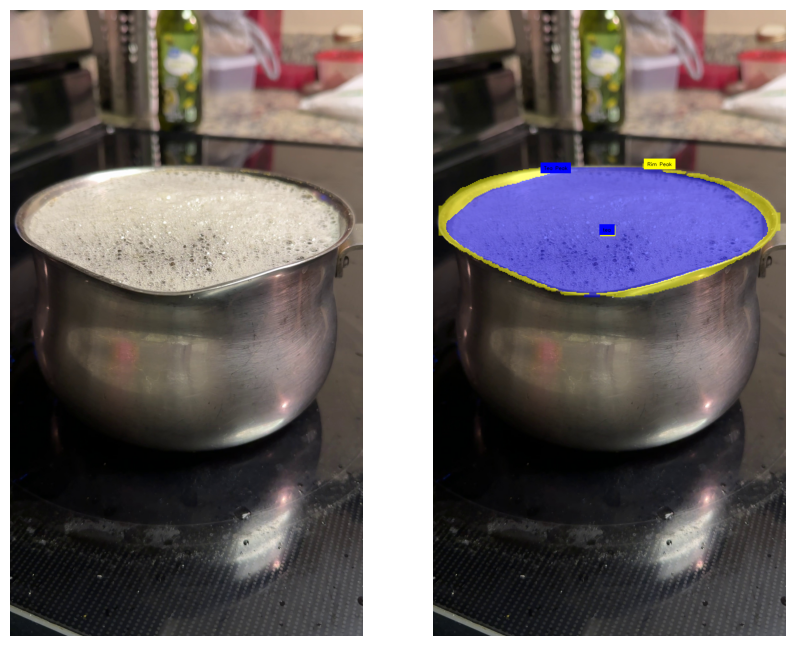

In [53]:
from ultralytics import YOLO
from PIL import Image
import os
import supervision as sv
import glob
import numpy as np

HOME = os.getcwd()
print(HOME)

model = YOLO(f"{HOME}/models/Epoch-500-best-yolo11-segmentation.pt")

colors = sv.ColorPalette.from_hex(
    ["#808080", "#ffff00", "#0000ff"]
)  # gray, yellow, blue
mask_annotator = sv.MaskAnnotator(color=colors)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK, text_position=sv.Position.CENTER, color=colors
)
def find_highest_point(mask_array):
    if len(mask_array) == 0:
        return None
    highest_idx = np.argmin(mask_array[:, 1])
    return (mask_array[highest_idx, 0], mask_array[highest_idx, 1])

for image in sorted(glob.glob(f"{HOME}/SAM-TRAIN-IMAGES/frames-tea-3/*.jpg")):
    image = Image.open(image)
    result = model.predict(image, conf=0.75)[0]
    # print("result.names",result.names)
    detections = sv.Detections.from_ultralytics(result)
    annotated_image = image.copy()
    mask_annotator.annotate(annotated_image, detections=detections)
    label_annotator.annotate(annotated_image, detections=detections)
    peaks = np.zeros((0,2))
    # print("result.masks",len(result.masks))
    for mask in result.masks:
        peaks = np.vstack((peaks, find_highest_point(mask.xy[0])))
    rim_peak, tea_peak = (peaks[1], peaks[0]) if peaks[0][1] > peaks[1][1] else (peaks[0], peaks[1])

    point_detection = sv.Detections(
          xyxy=np.array([
            [rim_peak[0], rim_peak[1], rim_peak[0]+1, rim_peak[1]+1],
            [tea_peak[0], tea_peak[1], tea_peak[0]+1, tea_peak[1]+1]
          ]),
          class_id=np.array([1,2]),
          confidence=np.array([1.0,1.0])
        )
    label_annotator.annotate(annotated_image, detections=point_detection, labels=["Rim Peak","Tea Peak"])
    print("rim_peak",rim_peak)
    print("tea_peak",tea_peak)
    sv.plot_images_grid([image, annotated_image], grid_size=(1, 2), size=(10, 10))
    if(rim_peak[1]+100 > tea_peak[1]):
        print("Tea about to spill over")
        break
    print("\n")
    

In [37]:
def find_highest_point(mask):
    y_coords, x_coords = np.where(mask)
    if len(y_coords) == 0:
        return 0
    max_y_idx = np.argmin(y_coords)
    return y_coords[max_y_idx]
